In [1]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns
from train import train
from models import Transformer, Low_rank
from utils import generate_data, entropy, power_unif_law, generate_each, last_position_law, gen_d_law, almost_rank_d
from interp import back_track, attention_map, by_attention, every_attention, new_computation_basis

In [2]:
#training transformer

#model params
N = 100
d = 10
nb_layers = 1
width = 0
depth = 0
para = 10
nb_head = 1
n_gram = 3
context_window = n_gram

#distribution params
alphas = [1, 1, 0.9]
nb_tokens=[40, 40, N]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

low_batch_size=2**10
low_num_batch=4000
low_lr=1e-3

device='cpu'
cosim = t.nn.CosineSimilarity(dim=-1)


model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr, next_token=True)

plt.plot(dict['Loss'], label=f'Next token')
print(sum(dict['Loss'][-100:-1])/100)


model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr, next_token=False)

plt.plot(dict['Loss'], label=f'Full divergence')
print(sum(dict['Loss'][-100:-1])/100)


#upper bound
ent=entropy(pi)
plt.plot([np.log(N)-ent for _ in dict['Loss']], label='unif div', color='red')

#lower bound
model_low = Low_rank(d, N, context_window, pi)
Data = generate_data(low_batch_size, low_num_batch, pi, context_window)
dict_low = train(model_low, Data, lr=low_lr)
best_loss = sum(dict_low['Loss'][-100:-1])/100
plt.plot([best_loss for _ in dict['Loss']], label='optimal div', color='green')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Divergence")
plt.title("Transformer's learning dynamics")
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
#Freezing Studies
N = 10
d = 5
nb_layers = 1
width = 0
depth = 1
para = 20
nb_head = 1
n_gram = 3
max_seq_len = n_gram
assert max_seq_len >= n_gram
assert n_gram == 3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[40, 40, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

for freeze_E, freeze_QKV, freeze_O, freeze_U in [
    (True, True, False, True), 
    (False, False, True, False),
]:
    freezer = {
        'freeze_E': freeze_E,
        'freeze_QKV': freeze_QKV,
        'freeze_O': freeze_O,
        'freeze_U': freeze_U,
    }
    t.manual_seed(333)
    model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
    model.freeze(freezer)
    dict = train(model, Data, lr=lr)
    print(freezer)
    print(sum(dict['Loss'][-100:-1])/100)


In [ ]:
#Scaling laws
loss=[]
alpha_1_list=[]
alpha_2_list=[]
N_list=[]
d_list=[]
h_list=[]
nb_layers_list=[]
nb_head_list=[]
para_list=[]
unif_loss=[]
best_loss=[]

context_window = 3
batch_size = 2**9
num_batch = 3000

count = 0
max_count = 99//8
for N in [100]:
    for alpha_1, alpha_2 in product([0.9],[0.6]):
        t.manual_seed(33)
        pi = power_unif_law([alpha_1, alpha_1, alpha_2], N) #to update
        Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
        ent = entropy(pi).item()
        for d in [10]:
            model_low = Low_rank(N, d, n_gram, context_window, pi)
            dict_low = train(model_low, Data, lr=1e-3)
            best = sum(dict_low['Loss'][-100:-1])/100
            for h in [0]:
                for depth in [1]:
                    for nb_head in [1]:
                        for nb_layers in [1]:
                            for parallel_heads in [i for i in range(1, 100, 8)]:
                                N_list.append(N)
                                d_list.append(d)
                                h_list.append(h)
                                nb_head_list.append(nb_head)
                                nb_layers_list.append(nb_layers)
                                para_list.append(parallel_heads)
                                alpha_1_list.append(alpha_1)
                                alpha_2_list.append(alpha_2)
                                unif_loss.append(-ent+np.log(N))
                                best_loss.append(best)

                                model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
                                dict = train(model, Data, lr=1e-3)
                                loss.append(sum(dict['Loss'][-100:-1])/100)

                                count+=1
                                print(count/max_count)

dict={
    'alpha_1': alpha_1_list,
    'alpha_2': alpha_2_list,
    'N': N_list,
    'd': d_list,
    'h': h_list,
    'nb_layers': nb_layers_list,
    'nb_head': nb_head_list,
    'para_head': para_list,
    'loss': loss,
    'unif_loss': unif_loss,
    'best_loss': best_loss,
}

data = pd.DataFrame(dict)
data.to_csv('scaling_csv_v3/scaling_mlp_free_3.csv', index=False)

In [5]:
#Architectures Studies

#model params
N = 100
d = 10
h = 0
depth = 1
nb_layers = 1
nb_head = 1
para = 10
n_gram = 3
max_seq_len = n_gram
assert max_seq_len >= n_gram
assert n_gram == 3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[40, 40, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

device='cpu'
cosim = t.nn.CosineSimilarity(dim=-1)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

for skip_res_connection in [False, True]:
    for skip_pos_QK in [False]:
        for skip_emb_QK in [False]:
            for skip_pos_OV in [False]:
                for skip_emb_OV in [False]:
                    skips = {
                                'skip_res_connection': skip_res_connection,
                                'skip_pos_QK': skip_pos_QK,
                                'skip_emb_QK': skip_emb_QK,
                                'skip_pos_OV': skip_pos_OV,
                                'skip_emb_OV': skip_emb_OV,
                            }
                    t.manual_seed(333)
                    model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
                    if not((skip_pos_OV and skip_emb_OV) or (skip_pos_QK and skip_emb_QK)):
                        dict = train(model, Data, lr=lr)
                        print(skips)
                        print(sum(dict['Loss'][-100:-1])/100)

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [01:23<00:00, 59.76it/s]


{'skip_res_connection': False, 'skip_pos_QK': False, 'skip_emb_QK': False, 'skip_pos_OV': False, 'skip_emb_OV': False}
0.9117191475629807


100%|██████████| 5000/5000 [01:24<00:00, 59.47it/s]

{'skip_res_connection': True, 'skip_pos_QK': False, 'skip_emb_QK': False, 'skip_pos_OV': False, 'skip_emb_OV': False}
0.8754868823289871


100%|██████████| 5000/5000 [00:42<00:00, 116.72it/s]


6.083942294935696e-05


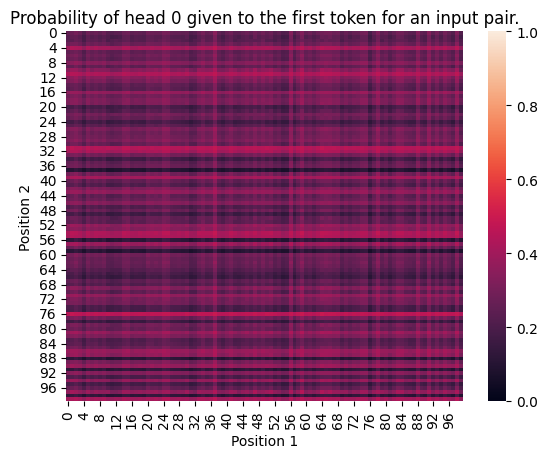

tensor([2.9347e+01, 1.0298e+00, 4.1663e-01, 2.1872e-01, 1.6572e-01, 1.2841e-01,
        1.0561e-01, 4.5328e-02, 3.5894e-02, 1.6583e-02, 1.0574e-02, 7.7494e-03,
        5.3705e-03, 4.2311e-03, 3.1065e-03, 2.7557e-03, 2.1164e-03, 1.4102e-03,
        1.3166e-03, 1.0810e-03, 1.0037e-03, 8.5521e-04, 7.2990e-04, 5.5328e-04,
        5.0677e-04, 4.6557e-04, 4.2783e-04, 3.5600e-04, 3.3412e-04, 3.0005e-04,
        2.8059e-04, 2.6102e-04, 2.3745e-04, 2.1915e-04, 1.8909e-04, 1.7972e-04,
        1.6251e-04, 1.3741e-04, 1.3470e-04, 1.1803e-04, 1.0958e-04, 9.5372e-05,
        9.0607e-05, 8.3150e-05, 7.4362e-05, 5.9416e-05, 5.8945e-05, 5.1891e-05,
        4.7823e-05, 4.1669e-05, 3.3656e-05, 3.1089e-05, 2.8254e-05, 2.4055e-05,
        2.2563e-05, 1.8887e-05, 1.6650e-05, 1.6059e-05, 1.4261e-05, 1.2816e-05,
        1.0929e-05, 9.7006e-06, 9.5728e-06, 8.9417e-06, 7.8957e-06, 7.0544e-06,
        6.7458e-06, 6.0981e-06, 5.2960e-06, 5.0938e-06, 4.5473e-06, 3.9407e-06,
        3.7452e-06, 3.4268e-06, 2.8544e-

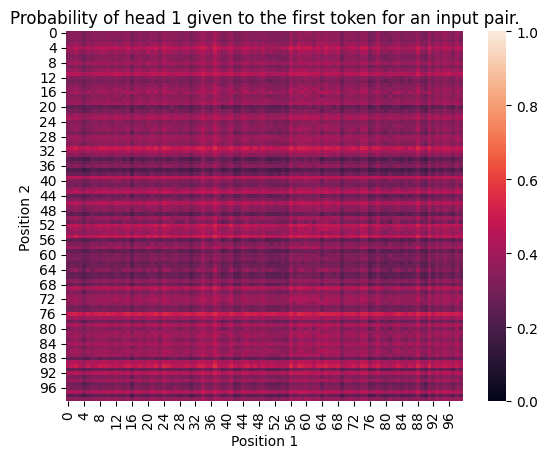

tensor([3.5976e+01, 9.4823e-01, 5.9603e-01, 4.2346e-01, 3.8726e-01, 3.2243e-01,
        1.4051e-01, 6.5225e-02, 3.5259e-02, 1.2624e-02, 1.2434e-02, 1.0083e-02,
        7.9874e-03, 6.2565e-03, 4.9767e-03, 4.4261e-03, 3.6604e-03, 2.5383e-03,
        2.2025e-03, 2.1590e-03, 1.8434e-03, 1.7023e-03, 1.2166e-03, 1.1415e-03,
        1.0259e-03, 9.3501e-04, 7.9297e-04, 6.8810e-04, 6.0142e-04, 5.7093e-04,
        4.8469e-04, 4.3820e-04, 4.0576e-04, 3.2711e-04, 3.1100e-04, 2.7113e-04,
        2.1163e-04, 2.0079e-04, 1.8176e-04, 1.5791e-04, 1.2637e-04, 1.2320e-04,
        1.1511e-04, 1.0878e-04, 1.0561e-04, 9.4214e-05, 8.6666e-05, 7.8380e-05,
        7.6300e-05, 6.9458e-05, 6.6249e-05, 5.9277e-05, 5.5655e-05, 4.8513e-05,
        4.3839e-05, 3.9932e-05, 3.8742e-05, 3.5854e-05, 3.0488e-05, 2.8249e-05,
        2.6510e-05, 2.6042e-05, 2.1777e-05, 2.0692e-05, 1.9295e-05, 1.7298e-05,
        1.6275e-05, 1.5607e-05, 1.1801e-05, 1.1151e-05, 1.0494e-05, 8.6699e-06,
        8.2326e-06, 7.4390e-06, 7.1681e-

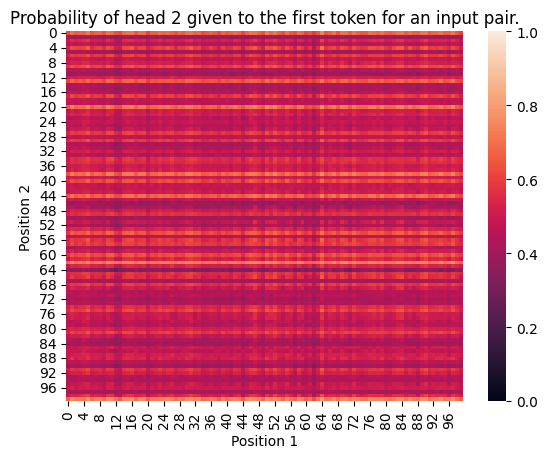

tensor([5.1387e+01, 8.3833e-01, 8.0470e-01, 6.0601e-01, 2.8433e-01, 2.3115e-01,
        1.7634e-01, 6.5490e-02, 4.3408e-02, 1.8071e-02, 1.1417e-02, 9.0042e-03,
        7.4683e-03, 4.4262e-03, 3.2894e-03, 2.5782e-03, 2.4520e-03, 1.7914e-03,
        1.5023e-03, 1.4072e-03, 1.1042e-03, 8.6501e-04, 7.9189e-04, 6.9065e-04,
        5.8483e-04, 5.3534e-04, 5.2647e-04, 5.0113e-04, 4.1607e-04, 3.8599e-04,
        3.5295e-04, 3.0310e-04, 2.8772e-04, 2.5521e-04, 2.2411e-04, 1.9993e-04,
        1.8322e-04, 1.7576e-04, 1.5480e-04, 1.5050e-04, 1.3437e-04, 1.2800e-04,
        1.1366e-04, 1.0875e-04, 9.0419e-05, 8.3434e-05, 8.1084e-05, 7.1853e-05,
        6.2987e-05, 6.2681e-05, 5.7377e-05, 4.7568e-05, 4.3963e-05, 4.2042e-05,
        4.0195e-05, 3.7183e-05, 3.4136e-05, 2.9972e-05, 2.7459e-05, 2.6194e-05,
        2.2973e-05, 2.1842e-05, 1.8245e-05, 1.7178e-05, 1.5115e-05, 1.3787e-05,
        1.3326e-05, 1.2450e-05, 1.1079e-05, 1.0785e-05, 1.0155e-05, 9.3821e-06,
        8.2179e-06, 7.7076e-06, 6.6244e-

In [4]:
#Attention map studies
N = 100
d = 10
nb_layers = 1
width = 0
depth = 1
para = 3
nb_head = 1
n_gram = 3
context_window = n_gram

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[10, 10, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

skips = {
    'skip_res_connection': True,
    'skip_pos_QK': False,
    'skip_emb_QK': False,
    'skip_pos_OV': False,
    'skip_emb_OV': False,
}

model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi, skips=skips)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
print(sum(dict['Loss'][-100:-1])/100)

for i in range(para):
    map = attention_map(model, 0, i).detach()
    sns.heatmap(map, vmin=0, vmax=1)
    plt.xlabel('Position 1')
    plt.ylabel('Position 2')
    plt.title(f"Probability of head {i} given to the first token for an input pair.")
    plt.show()

    S = t.linalg.svdvals(map)
    print(S)

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 4000/4000 [00:16<00:00, 242.48it/s]


0.0010165569605305792
dict_keys(['res_0', 'pos', 'para_0_layer_0', 'para_1_layer_0', 'res_after_attn_layer_0', 'mlp_0', 'res_after_mlp_layer_0', 'logits'])
tensor([-0.8562, -1.5120,  0.7009,  0.0882, -0.7705,  0.3041, -0.4151,  0.5844,
         1.3770, -0.4175]) tensor(2.6055)
tensor([ 1.4422,  1.0480, -3.4379, -0.9462, -2.5247, -1.9525,  1.4573,  5.2785,
         0.8686,  1.9412]) tensor(7.7838)
tensor([ 0.5860, -0.4640, -2.7370, -0.8580, -3.2952, -1.6483,  1.0422,  5.8628,
         2.2456,  1.5236])


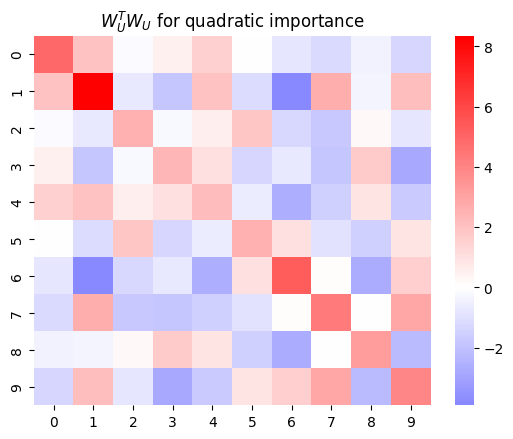

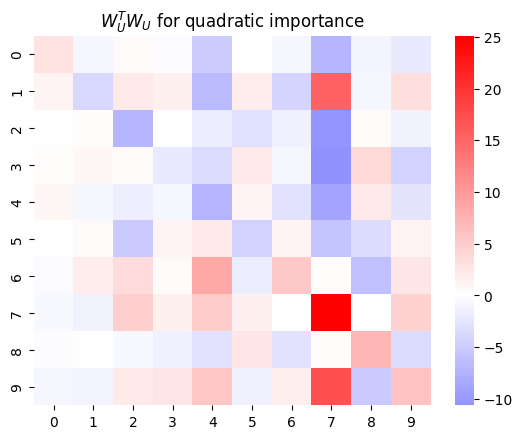

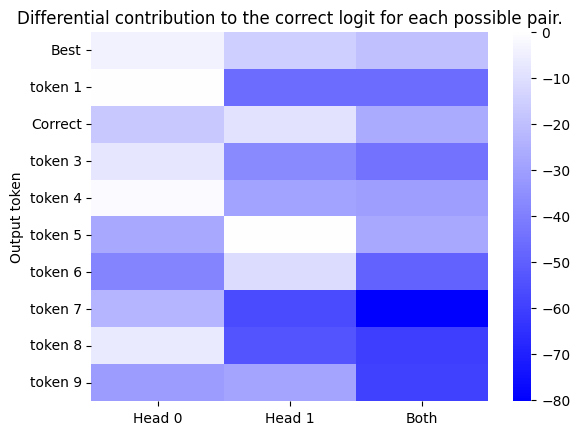

tensor([ True, False, False, False, False, False, False, False, False, False])
tensor([ True,  True, False, False, False, False, False, False, False, False])
tensor([ True, False, False, False, False, False, False, False, False, False])
tensor([ True, False,  True, False, False, False, False, False, False, False])
tensor([ True,  True,  True,  True,  True, False, False, False,  True, False])
tensor([ True, False,  True, False, False, False, False, False, False, False])
tensor([False, False, False, False, False,  True,  True,  True, False,  True])
tensor([False, False, False, False, False, False, False, False, False, False])
tensor([False, False,  True,  True,  True, False, False, False,  True, False])
tensor([False, False, False, False, False, False, False, False, False, False])


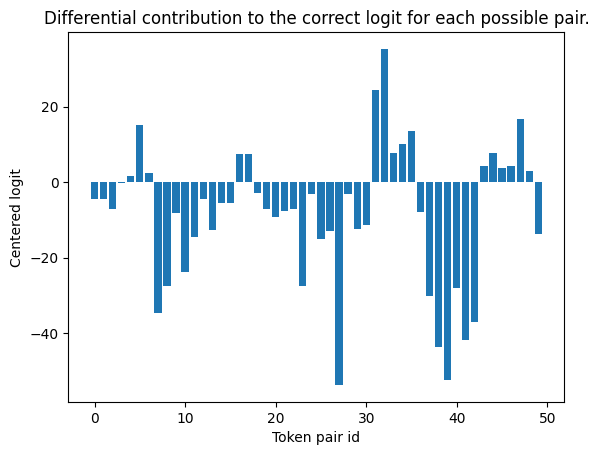

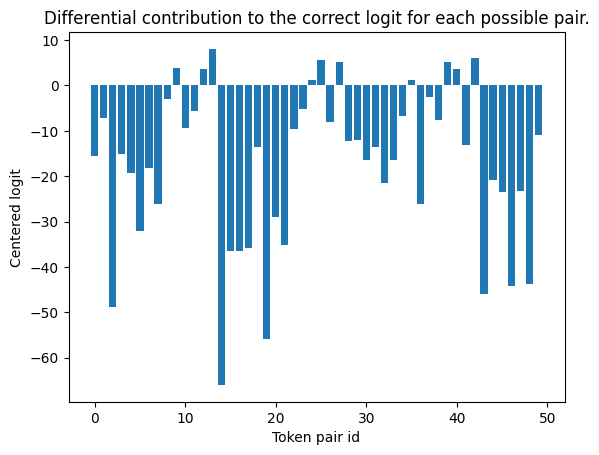

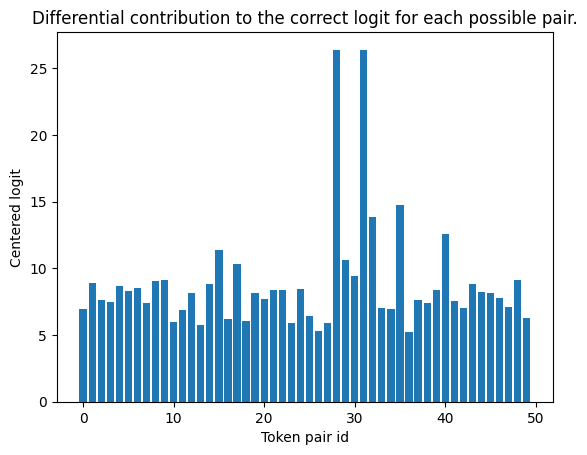

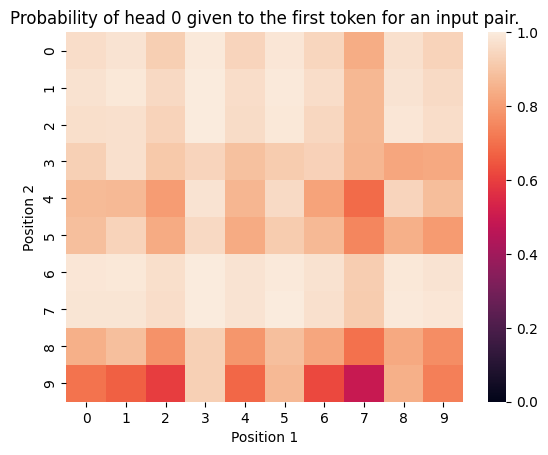

tensor([9.0327e+00, 3.8000e-01, 1.7081e-01, 4.7858e-02, 2.5325e-02, 9.8547e-03,
        4.5026e-03, 1.1876e-03, 3.7421e-04, 1.1736e-05])


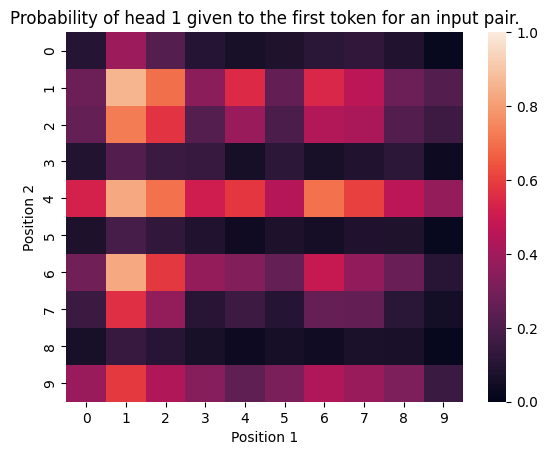

tensor([3.4224e+00, 4.2440e-01, 2.7564e-01, 1.3714e-01, 9.7685e-02, 3.9113e-02,
        1.2051e-02, 4.7192e-03, 8.3241e-04, 1.0289e-04])


In [23]:
#Per head logit contribution studies
N = 10
d = 5
nb_layers = 1
width = 0
depth = 1
para = 2
nb_head = 1
n_gram = 3
context_window = n_gram

#learning params
batch_size=2**9
num_batch=4000
lr=1e-3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[10, 5, 1]
seed = 2222
t.manual_seed(seed)
pi = power_unif_law(alphas, nb_tokens, N)

skips = {
    'skip_res_connection': True,
    'skip_pos_QK': False,
    'skip_emb_QK': False,
    'skip_pos_OV': False,
    'skip_emb_OV': False,
}

t.manual_seed(seed)
model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi, skips=skips)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
examples = generate_each(pi)
t.manual_seed(seed)
dict = train(model, Data, lr=lr, seed=seed)
print(sum(dict['Loss'][-10:-1])/10)

contribution = back_track(model, examples)
new_contribution = new_computation_basis(model, examples)
print(new_contribution.keys())
ex = 10
print(new_contribution[f'para_{0}_layer_{0}'][ex, 2], t.norm(new_contribution[f'para_{0}_layer_{0}'][ex, 2]))
print(new_contribution[f'para_{1}_layer_{0}'][ex, 2], t.norm(new_contribution[f'para_{1}_layer_{0}'][ex, 2]))
print(new_contribution[f'para_{1}_layer_{0}'][ex, 2]+new_contribution[f'para_{0}_layer_{0}'][ex, 2])

W_U = model.unemb.weight.detach()
map = t.einsum('Nd, nd -> Nn', W_U, W_U)
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$W_U^TW_U$ for quadratic importance')
plt.show()

map = map*(new_contribution[f'para_{1}_layer_{0}'][ex, 2]+new_contribution[f'para_{0}_layer_{0}'][ex, 2]).unsqueeze(0)
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$W_U^TW_U$ for quadratic importance')
plt.show()

every_attention(contribution, examples[ex].unsqueeze(0), 0)

_, computations = model.forward(examples, out_computation=True)
for i in range(N):
    #print(computations['logits'][examples[:, 2] == 0].mean(0)[2] - (computations['logits'][examples[:, 2] == 0].mean(0)[2]).mean())
    A = W_U@computations[f'para_{0}_layer_{0}'][examples[:, 2] == i].mean(0)[2] - (W_U@computations[f'para_{0}_layer_{0}'][examples[:, 2] == i].mean(0)[2]).mean()
    B = W_U@computations[f'para_{1}_layer_{0}'][examples[:, 2] == i].mean(0)[2] - (W_U@computations[f'para_{1}_layer_{0}'][examples[:, 2] == i].mean(0)[2]).mean()
    #print(A)
    #print(B)
    print(t.logical_and(t.logical_and(A*B > 0, A > 0), B > 0))

for i in range(para):
    by_attention(contribution, examples, 0, i, sort=False, method='solo')

by_attention(contribution, examples, 0, i, sort=False, method="group")

map = attention_map(model, 0, 0).detach()
sns.heatmap(map, vmin=0, vmax=1)
plt.xlabel('Position 1')
plt.ylabel('Position 2')
plt.title(f"Probability of head {0} given to the first token for an input pair.")
plt.show()

S = t.linalg.svdvals(map)
print(S)

map = attention_map(model, 0, 1).detach()
sns.heatmap(map, vmin=0, vmax=1)
plt.xlabel('Position 1')
plt.ylabel('Position 2')
plt.title(f"Probability of head {1} given to the first token for an input pair.")
plt.show()

S = t.linalg.svdvals(map)
print(S)

IntSlider(value=4, description='Select Heatmap:', max=4)

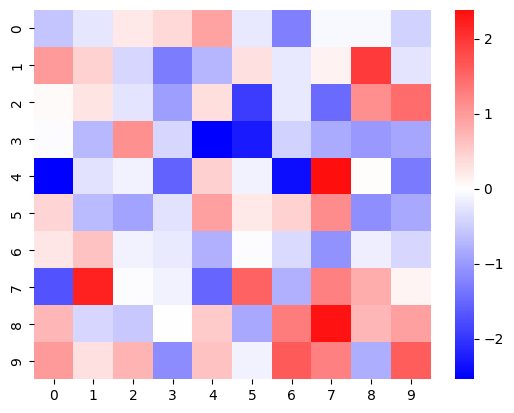

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Generate test heatmap data
def generate_heatmap_data(num_heatmaps, size=(10, 10)):
    return [np.random.randn(size[0], size[1]) for _ in range(num_heatmaps)]

# Plotting function
def plot_heatmap(data):
    sns.heatmap(data, center=0, cmap='bwr')

# Number of heatmaps and their sizes
num_heatmaps = 5
heatmap_size = (10, 10)
heatmap_list = generate_heatmap_data(num_heatmaps, heatmap_size)

# Widget setup
def display_heatmaps(heatmap_list):
    num_heatmaps = len(heatmap_list)
    slider = widgets.IntSlider(value=0, min=0, max=num_heatmaps-1, step=1, description='Select Heatmap:')

    plot_heatmap(heatmap_list[0])  # Display the first heatmap initially

    def update_heatmap(change):
        clear_output(wait=True)
        plot_heatmap(heatmap_list[change['new']])
        display(slider)

    slider.observe(update_heatmap, names='value')

    display(slider)

display_heatmaps(heatmap_list)

100%|██████████| 5000/5000 [00:07<00:00, 712.00it/s]


0.04469699591398239


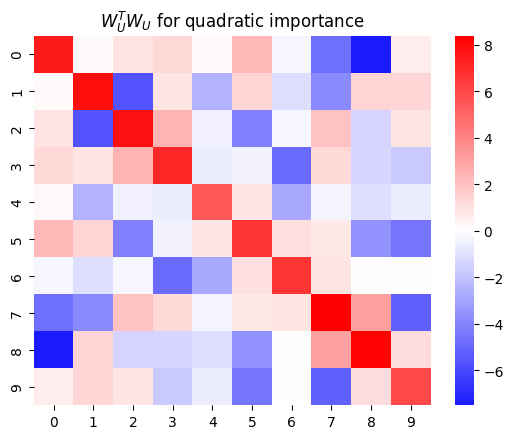

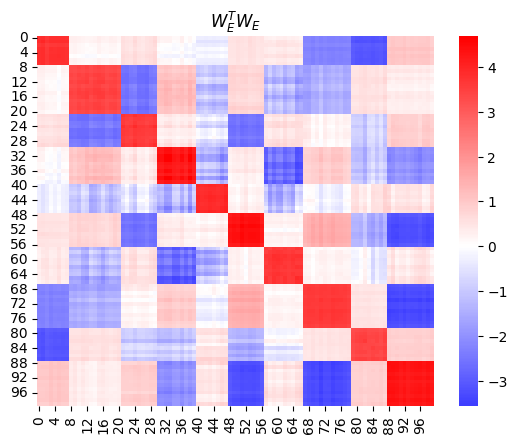

tensor([5.2736, 5.3458, 5.0520, 5.2238, 5.2351, 5.2236, 5.2638, 5.2193, 5.0598,
        5.0075, 5.1993, 5.0351, 5.1520, 5.1396, 5.2630, 5.2813, 5.1121, 4.9994,
        5.1697, 5.1970, 4.9676, 5.3134, 5.1848, 5.1211, 5.3835, 5.2643, 5.2323,
        5.1315, 5.1697, 5.3083, 5.3668, 5.3429, 5.5321, 5.5131, 5.3691, 5.2672,
        5.3713, 5.2282, 5.5339, 5.3196, 4.6015, 4.4759, 4.5359, 4.6329, 4.6010,
        4.4742, 4.4712, 4.6589, 5.2149, 5.3093, 5.2732, 5.4846, 5.3211, 5.4158,
        5.4037, 5.3690, 5.1498, 4.7365, 4.8691, 4.9971, 5.0136, 4.9447, 4.8644,
        4.8073, 4.9332, 4.8385, 4.8525, 5.3956, 5.4715, 5.3985, 5.3444, 5.4569,
        5.4404, 5.4012, 5.4979, 5.4731, 5.4380, 5.4191, 5.2772, 5.0072, 5.1381,
        5.2651, 5.1760, 5.2267, 5.1978, 5.1597, 5.0919, 5.2005, 5.0506, 5.1054,
        5.0532, 4.9259, 5.0223, 4.8933, 4.9788, 4.9996, 4.9848, 4.9697, 5.1090,
        4.9408])


/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [00:35<00:00, 139.63it/s]


0.1978881412744522


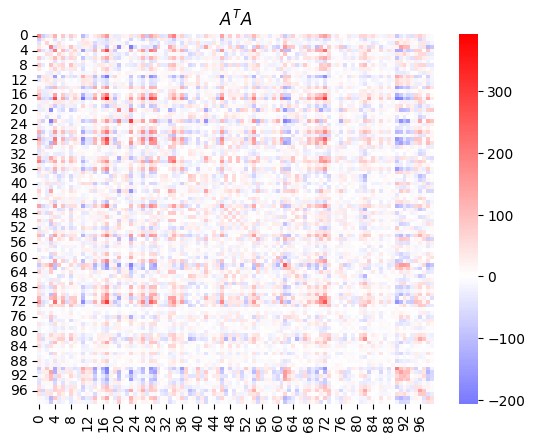

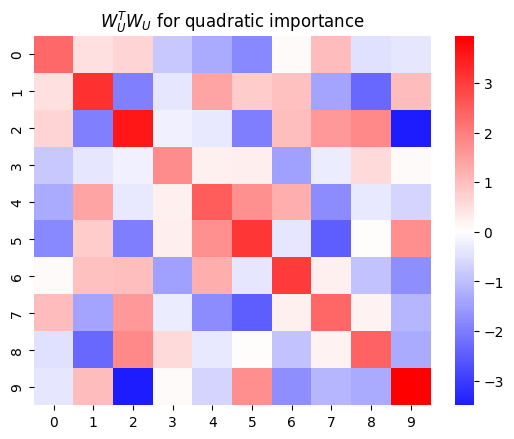

tensor([ 10.7063,  -6.1915,  -4.5736,  -4.0034,  12.2781,   1.3592,  10.5073,
         -3.3856,  -6.4943,  -4.5056,  -0.0491,   1.4804,   0.1443,  -3.0709,
          1.6542,  -1.7068,  -3.4820,   0.5261,   5.2771,  -6.0551,  22.3867,
         -1.0257,  -3.1224, -15.3025,  -7.5510,   2.8954,   7.3486,  -6.9224,
          9.4705,  -3.9167,   3.8436,  -3.3918,  -1.7791,   8.0339,   8.5740,
         -1.2570,  -7.7018,   3.3020,   2.4298,   2.4625,   9.6632,  -2.6674,
         -6.9147,  -5.3654,   4.8957,   4.6361, -12.4134,  -2.1968,  -6.7502,
         -1.2438,  -6.4272,  -1.1350,  10.2291,  -6.4781, -16.7695,  -5.2992,
         -2.1519,  -7.6358,   3.8764,   4.6167,  -8.4708,   8.9877,  12.4939,
         -5.1326,  -7.5613,  -4.6668,  -3.1428,   0.6289,   6.0517,   4.3159,
          7.5807,  19.7267,  23.1404,   6.1479,  -0.8566,   0.4290,   1.9904,
         -1.1839,   3.9691,  -0.7145,  -0.8049,   5.8085,   1.5640,  -8.3140,
          5.6851,   1.3731,  -6.7572,  -1.2020,   1.2096,   3.58

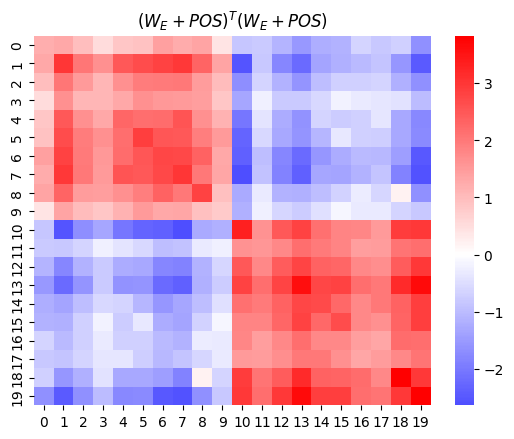

"#distribution params\nheatmap_list = []\nfor i in range(10):\n    t.manual_seed(2108)\n    nb_tokens = [N, N]\n    pi = last_position_law([N, N], N, i/2)\n\n    model = Low_rank(d, N, context_window, pi)\n    Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)\n    dict = train(model, Data, lr=lr)\n    print(sum(dict['Loss'][-100:-1])/100)\n\n    W_U = model.unemb.weight.detach()\n    map = t.einsum('Nd, nd -> Nn', W_U, W_U)\n    heatmap_list.append(map)\n    #sns.heatmap(map, center=0, cmap='bwr')\n    #plt.show()\n\ndisplay_heatmaps(heatmap_list)"

In [7]:
#Superposition
N = 10
d = 5
context_window = 3

#learning params
batch_size=2**9
num_batch=5000
lr=1e-3

t.manual_seed(2108) #2108 and 1
nb_tokens = [N, N]
pi = last_position_law([N, N], N, 0, 0.95)

model = Low_rank(d, N, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
print(sum(dict['Loss'][-100:-1])/100)

W_U = model.unemb.weight.detach()
W_U = W_U#/t.norm(W_U, dim=-1, keepdim=True)
map = t.einsum('Nd, nd -> Nn', W_U, W_U)
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$W_U^TW_U$ for quadratic importance')
plt.show()


W_E = model.word_emb.weight.detach()
w_e = []
examples = generate_each(pi, eps=0.1/(N**2))
indices = []
for ex in examples:
    indices.append(ex[0]+ex[1]*N)
indices = t.Tensor(indices).to(t.int)
W_E = W_E[indices]#/t.norm(W_E[indices], dim=-1, keepdim=True)
map = W_E@W_E.mH
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$W_E^TW_E$')
plt.show()

print((W_U@W_E.mH)[examples[t.arange(N**2), 2], t.arange(N**2)]) #okokok

model = Transformer(d, N, nb_layers=1, width=0, depth=0, parallel_heads=5, nb_head=1, context_window=context_window, pi=pi)
#model.unemb.weight = t.nn.Parameter(W_U, requires_grad=False)
dict = train(model, Data, lr=lr)
print(sum(dict['Loss'][-100:-1])/100)

with t.no_grad():
    _, computations = model.forward(examples, out_computation=True)
W_E = computations[f'res_after_mlp_layer_{0}'].detach()[:, 2, :]
W_E = W_E[indices]#/t.norm(W_E[indices], dim=-1, keepdim=True)
map = W_E@W_E.mH
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$A^TA$')
plt.show()

W_U = model.unemb.weight.detach()
W_U = W_U#/t.norm(W_U, dim=-1, keepdim=True)
map = t.einsum('Nd, nd -> Nn', W_U, W_U)
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$W_U^TW_U$ for quadratic importance')
plt.show()

print((W_U@W_E.mH)[examples[t.arange(N**2), 2], t.arange(N**2)])

W_E = model.word_emb.weight.detach()
POS = model.pos_emb.weight.detach()[:2]
W_E = (W_E.unsqueeze(0) + POS.unsqueeze(1)).flatten(0, 1)
map = W_E@W_E.mH
sns.heatmap(map, center=0, cmap='bwr')
plt.title(r'$(W_E+POS)^T(W_E+POS)$')
plt.show()

"""map = attention_map(model, 0, 0).detach()
sns.heatmap(map, vmin=0, vmax=1)
plt.xlabel('Position 1')
plt.ylabel('Position 2')
plt.title(f"Probability of head {0} given to the first token for an input pair.")
plt.show()

S = t.linalg.svdvals(map)
print(S)

map = attention_map(model, 0, 1).detach()
sns.heatmap(map, vmin=0, vmax=1)
plt.xlabel('Position 1')
plt.ylabel('Position 2')
plt.title(f"Probability of head {1} given to the first token for an input pair.")
plt.show()

S = t.linalg.svdvals(map)
print(S)"""

"""#distribution params
heatmap_list = []
for i in range(10):
    t.manual_seed(2108)
    nb_tokens = [N, N]
    pi = last_position_law([N, N], N, i/2)

    model = Low_rank(d, N, context_window, pi)
    Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
    dict = train(model, Data, lr=lr)
    print(sum(dict['Loss'][-100:-1])/100)

    W_U = model.unemb.weight.detach()
    map = t.einsum('Nd, nd -> Nn', W_U, W_U)
    heatmap_list.append(map)
    #sns.heatmap(map, center=0, cmap='bwr')
    #plt.show()

display_heatmaps(heatmap_list)"""

In [34]:
"""remembering d-directions
Hypothesis: when the distribution is almost uniform, then W_U learn the d most important directions that generate the logits.

Results: this is a good approximation but is not exactly what happens.
"""

N = 10
d = 5
context_window = 3

#learning params
batch_size=2**9
num_batch=5000
lr=1e-3

#distribution params
axis_aligned = []
non_axis_aligned = []
random = []
nb_tokens=[N, N]
num_rep = 3
t.manual_seed(666)
for dim in range(d, N+1):
    mean = 0.
    for _ in range(num_rep):
        pi, W = gen_d_law(nb_tokens, N, dim, axis_aligned=True)
        U, S, V = t.linalg.svd(W)
        W = (U[:, :d]*S[:d])@V[:d, :d]

        model = Low_rank(d, N, context_window, pi)
        Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
        dict = train(model, Data, lr=lr, seed=(_+1)*(dim+1))

        W_U = model.unemb.weight.detach()
        mean += t.norm(W@t.linalg.inv(W.mH@W)@W.mH-W_U@t.linalg.inv(W_U.mH@W_U)@W_U.mH).item()
    axis_aligned.append(mean/num_rep)

    mean = 0.
    for _ in range(num_rep):
        pi, W = gen_d_law(nb_tokens, N, dim, axis_aligned=False)
        U, S, V = t.linalg.svd(W)
        W = (U[:, :d]*S[:d])@V[:d, :d]

        model = Low_rank(d, N, context_window, pi)
        Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
        dict = train(model, Data, lr=lr, seed=(_+1)*(dim+1))

        W_U = model.unemb.weight.detach()
        mean += t.norm(W@t.linalg.inv(W.mH@W)@W.mH-W_U@t.linalg.inv(W_U.mH@W_U)@W_U.mH).item()
    non_axis_aligned.append(mean/num_rep)

    mean = 0.
    for _ in range(30):
        Q = t.randn_like(W)
        mean += t.norm(Q@t.linalg.inv(Q.mH@Q)@Q.mH-W@t.linalg.inv(W.mH@W)@W.mH).item()
    random.append(mean/30)

X = [dim for dim in range(d, N+1)]
plt.plot(X, axis_aligned, label='axis aligned')
plt.plot(X, non_axis_aligned, label='axis unaligned')
plt.plot(X, random, label='random baseline')
plt.legend()
plt.xlabel('Embedding dimension')
plt.ylabel('L2 matrix distance')
plt.title('Distance between W_U and low rank log-prob')
plt.show()

 33%|███▎      | 1659/5000 [00:02<00:04, 693.06it/s]


KeyboardInterrupt: 

In [5]:
#d direction but nice
N = 10
d = 5
context_window = 3

#learning params
batch_size=2**10
num_batch=5000
lr=5e-4

#distribution params
axis_aligned = []
non_axis_aligned = []
random = []
nb_tokens=[N, N]
t.manual_seed(66)

pi = almost_rank_d(nb_tokens, N, d+1, axis_aligned=False)

model = Low_rank(d, N, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
print(sum(dict['Loss'][-100:-1])/100)

W_E = model.word_emb.weight.detach()
W_U = model.unemb.weight.detach()

f1 = W_E@W_U.mH #real
L = t.log(pi[2].flatten(0, 1))-t.log(pi[2].flatten(0,1)).mean(-1, keepdim=True)
PI = pi[2].flatten(0, 1)
Z = f1 - L - ((f1-L)*PI).sum(-1, keepdim=True)
print(t.log((t.exp(Z)*PI).sum(-1)).mean())

EL = (L*PI).sum(-1, keepdim=True)
COV = W_U.mH@((L*PI-EL*PI).mH)
VAR = t.einsum('Nd, ND, MN -> MdD', W_U, W_U, PI) - t.einsum('Nd, nD, MN, Mn -> MdD', W_U, W_U, PI, PI)
w_e = t.einsum('MdD, dM -> MD', t.linalg.inv(VAR), COV)
cosim = t.nn.CosineSimilarity(dim=-1)
#print(cosim(w_e, W_E))

f2 = w_e@W_U.mH #th
Z = f2 - L - ((f2-L)*PI).sum(-1, keepdim=True)
print(t.log((t.exp(Z)*PI).sum(-1)).mean())

U, S, V = t.linalg.svd(t.log(pi[2].flatten(0,1))-t.log(pi[2].flatten(0,1)).mean(-1, keepdim=True))
f = t.einsum('Md, d, dN -> MN', U[:, :d], S[:d], V[:d]) #least-square
Z = f - L - ((f-L)*PI).sum(-1, keepdim=True)
print(t.log((t.exp(Z)*PI).sum(-1)).mean())

100%|██████████| 5000/5000 [00:11<00:00, 421.38it/s]

0.026685121059417723
tensor([ 1.0415,  1.9363,  3.1598,  5.0069,  1.9707,  1.5509, 12.1780,  2.3745,
         5.9765,  5.2128,  3.2085,  1.0149,  1.8449, 11.2013, 13.2905,  3.2395,
         7.7813,  3.9956,  1.3935, 13.2777,  2.3417,  1.5386,  1.0061,  3.3038,
         7.0918,  4.2550,  5.5623,  4.0351,  1.6059,  3.8768,  3.6817, 14.5698,
         4.6992,  1.0136,  3.2237,  1.2154,  3.1014,  2.1661,  1.7571, 17.6890,
         2.9061, 17.2756,  3.9689,  3.5767,  1.0110,  1.8904,  5.1125,  4.2290,
         2.6369,  3.5960,  1.4123,  2.9827,  7.4260,  1.2031,  1.8818,  1.0039,
         1.2683,  6.4286,  6.0821,  2.9564, 18.0613,  6.1706,  3.1082,  3.6319,
         8.0174,  1.2654,  1.0123,  2.1825,  2.7111,  4.1964,  2.7695,  4.0028,
         6.4231,  2.2761,  3.9487,  8.7244,  2.2082,  1.0183,  4.2089,  3.5555,
        17.7348,  1.4154,  1.5374,  2.2965,  4.1503,  2.8886,  2.9644,  3.0730,
         1.1668,  1.5287,  6.6125, 10.9166,  5.9564, 10.5734,  2.3835,  2.6210,
         3.6969,  4